# Spatio-Temporal Prediction Examples
In this page we are simply running files from the
`examples` folder of the `TimeseriesPrediction` package.

This is how you can (programmatically) find this folder:
```julia
using TimeseriesPrediction
exdir = dirname(dirname(pathof(TimeseriesPrediction)))*"/examples"
```

## Temporal Prediction: Kuramoto-Sivashinsky
*(this requires `FFTW` to be installed)*

This example predicts the temporal evolution of a one-dimensional field
U, along with a time vector T,
which has to be represented as vectors of vectors.
Where the field comes from does not matter, but to make the example
runnable we load one of the test systems of `TimeseriesPrediction`.

In this example we use the solution of Kuramoto Sivashinsky equation.

Importantly, the results are compared with the "real" evolution of the
system.

In the plots, the x axis is space and y axis is time.

### Produce field U (Kuramoto Sivashinsky)

In [1]:
using PyPlot
using TimeseriesPrediction

testdir = dirname(dirname(pathof(TimeseriesPrediction)))*"/test"
@assert isdir(testdir)
include(testdir*"/ks_solver.jl")

Ntrain = 10000
p = 100
N = Ntrain + p

U, T = KuramotoSivashinsky(64, 22, N÷4, 0.25)
summary(U)

"10101-element Array{Array{Float64,1},1}"

### Temporal prediction of field U

In [3]:
Q = length(U[1]) # spatial length
pool = U[1:Ntrain]
test = U[Ntrain:N]

D = 10
τ = 1
B = 10
k = 1
ntype = FixedMassNeighborhood(4)
method = AverageLocalModel()

em = cubic_shell_embedding(pool, D,τ,B,k,PeriodicBoundary())
pcaem= PCAEmbedding(pool,em)

@time pred = temporalprediction(pool,pcaem, p;ntype=ntype, method=method, progress = false)

err = [abs.(test[i]-pred[i]) for i=1:p+1]
println("Maximum error: ", maximum(maximum(e) for e in err))

  1.489010 seconds (103.03 k allocations: 121.413 MiB, 6.90% gc time)
Maximum error: 7.489722699875936


### Plot the result

Deduce field extremal values

In [4]:
vmax = max(maximum(maximum(s) for s in test),
           maximum(maximum(s) for s in pred))
vmin = min(minimum(minimum(s) for s in test),
           minimum(minimum(s) for s in pred))
# Transform data for imshow
ptest = cat(test..., dims = 2)
ppred = cat(pred..., dims = 2)
perr = cat(err..., dims = 2)

64×101 Array{Float64,2}:
 0.0  0.117557     0.093332    0.0995133    …  0.176435  0.428045  1.12381
 0.0  0.0844138    0.0624008   0.0627831       1.03725   0.634373  0.149066
 0.0  0.0487361    0.0268789   0.0249753       1.51933   1.35378   1.12772
 0.0  0.0430553    0.00531474  0.00402415      1.65941   1.72697   1.76369
 0.0  0.0550993    0.00717697  0.00488774      1.54245   1.80927   2.07716
 0.0  0.0513383    0.0131881   0.00198239   …  1.27599   1.69305   2.13234
 0.0  0.0394528    0.0126422   0.0254385       0.977606  1.4845    2.02576
 0.0  0.0222963    0.0454558   0.0583722       0.749201  1.27235   1.84884
 0.0  0.0113543    0.0875975   0.102984        0.625136  1.10491   1.6342
 0.0  0.000283291  0.121417    0.137955        0.64153   1.04758   1.47385
 0.0  0.011095     0.142542    0.0794819    …  0.841344  1.15083   1.46107
 0.0  0.0125788    0.0984907   0.000534593     1.18697   1.39393   1.5837
 0.0  0.0134808    0.0804119   0.0294581       1.60588   1.72122   1.81002
 

plot plot plot

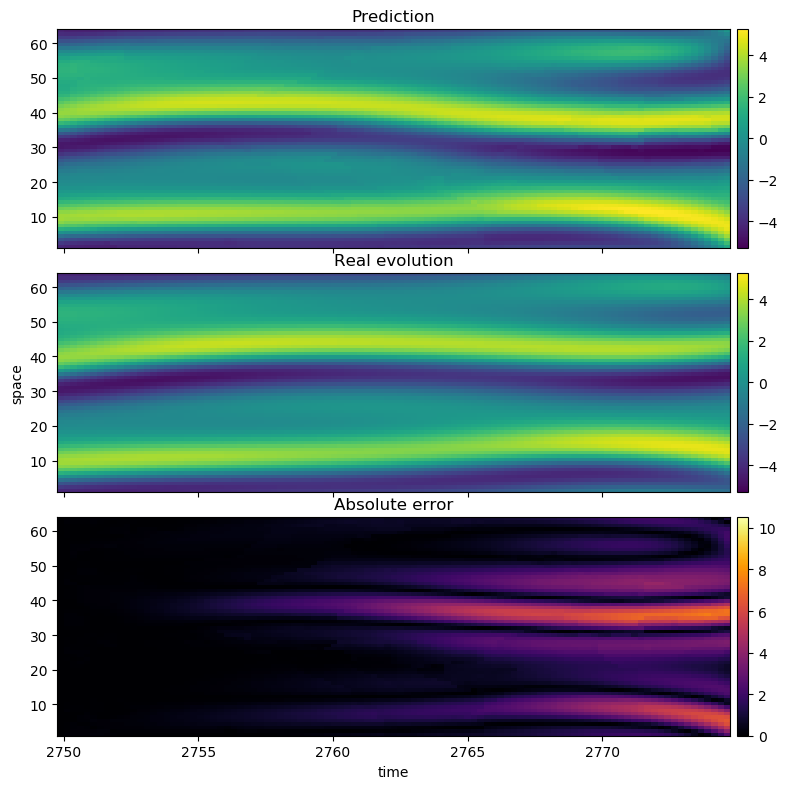

In [7]:
fig = figure(figsize=(8,8))
ax1 = subplot2grid((3,1), (0,0))
ax2 = subplot2grid((3,1), (1,0))
ax3 = subplot2grid((3,1), (2,0));

im1 = ax1.imshow(ppred, cmap="viridis", vmin = vmin, vmax = vmax,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
im2 = ax2.imshow(ptest, cmap="viridis", vmin = vmin, vmax = vmax,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
im3 = ax3.imshow(perr, cmap="inferno", vmin = 0, vmax = vmax-vmin,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))

for (j, (im, ax)) in enumerate(zip([im1,im2,im3], [ax1,ax2,ax3]))
    colorbar(im, ax = ax, fraction=0.04, pad=0.01)# format="%.1f")
    if j < 3
        ax.set_xticklabels([])
    end
end
ax1.set_title("Prediction")
ax2.set_title("Real evolution")
ax3.set_title("Absolute error")

ax2.set_ylabel("space")
ax3.set_xlabel("time")
tight_layout(w_pad=0.1, h_pad=0.00001)

## Cross Prediction: Barkley Model

This example cross-predicts a field U from a field V.
Both fields have to be represented as vectors of matrices.
Where the fields come from does not matter, but to make the example
runnable we load one of the test systems of TimeseriesPrediction.

This example uses cubic shell embedding and a linear Barkley model.

Importantly, the results are compared with the "real" evolution of the
system.

### Simulate a test system

In [8]:
using PyPlot
using TimeseriesPrediction

testdir = dirname(dirname(pathof(TimeseriesPrediction)))*"/test"
@assert isdir(testdir)
include(testdir*"/system_defs.jl")

Ttrain = 500
Ttest = 10
T = Ttrain + Ttest

U, V = barkley(T;tskip=100, ssize=(50,50))
summary(U)

"510-element Array{Array{Float64,2},1}"

### Cross predict field U from field V

In [9]:
D = 5
τ = 1
B = 1
k = 1
bc = PeriodicBoundary()

source_train = V[1: Ttrain]
target_train = U[1: Ttrain]
source_pred  = V[Ttrain  - D*τ + 1:  T]
target_test  = U[Ttrain        + 1:  T]

em = cubic_shell_embedding(source_train, D,τ,B,k,bc)
pcaem = PCAEmbedding(source_train, em; maxoutdim=5) # PCA speeds things up!

@time target_pred = crossprediction(source_train, target_train, source_pred, em;
progress = false)

err = [abs.(target_test[i]-target_pred[i]) for i=1:Ttest]

println("Maximum error: ", maximum(maximum(e) for e in err))

 31.544851 seconds (1.92 M allocations: 1.181 GiB, 0.10% gc time)
Maximum error: 0.45439297277439983


### Plot prediction

Deduce field extremal values

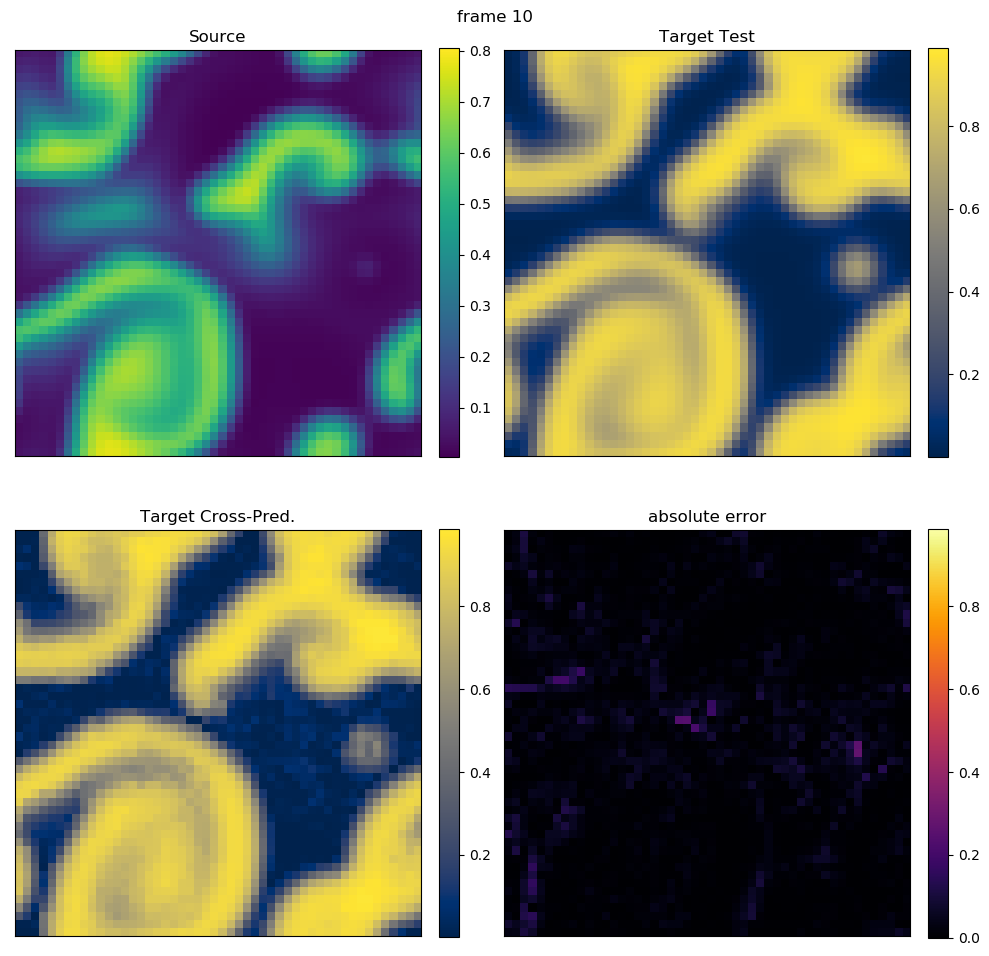

PyObject Text(0.5, 0.98, 'frame 10')

In [12]:
source_max = maximum(maximum(s) for s in source_pred)
target_max = max(maximum(maximum(s) for s in target_test),
                 maximum(maximum(s) for s in target_pred))
source_min = minimum(minimum(s) for s in source_pred)
target_min = min(minimum(minimum(s) for s in target_test),
                 minimum(minimum(s) for s in target_pred))

fig = nothing
i = length(err)

fig = figure(figsize=(10,10))
ax1 = subplot2grid((2,2), (0,0))
ax2 = subplot2grid((2,2), (0,1))
ax3 = subplot2grid((2,2), (1,0))
ax4 = subplot2grid((2,2), (1,1))
im1 = ax1.imshow(source_pred[i], cmap="viridis", vmin = source_min, vmax = source_max)
im2 = ax2.imshow(target_test[i], cmap="cividis", vmin = target_min, vmax = target_max)
im3 = ax3.imshow(target_pred[i], cmap="cividis", vmin = target_min, vmax = target_max)
im4 = ax4.imshow(err[i], cmap="inferno", vmin = 0, vmax = target_max - target_min)
for (im, ax) in zip([im1,im2,im3,im4], [ax1,ax2,ax3,ax4])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    colorbar(im, ax = ax, fraction=0.046, pad=0.04)#, format="%.1f")
end
ax1.set_title("Source")
ax2.set_title("Target Test")
ax3.set_title("Target Cross-Pred.")
ax4.set_title("absolute error")
tight_layout(w_pad=0.6, h_pad=0.00001)
suptitle("frame $i")

## Temporal Prediction: Periodic Nonlinear Barkley Model

This example predicts the temporal evolution of a field U,
which has to be represented as vectors of matrices.
Where the field comes from does not matter, but to make the example
runnable we load one of the test systems of TimeseriesPrediction.

This example uses light cone embedding and a nonlinear Barkley model.

Importantly, the results are compared with the "real" evolution of the
system.

### Simulate a test system

In [13]:
using PyPlot
using TimeseriesPrediction

testdir = dirname(dirname(pathof(TimeseriesPrediction)))*"/test"
@assert isdir(testdir)
include(testdir*"/system_defs.jl")

Ttrain = 300
Ttest = 5
T = Ttrain + Ttest

init = [ 0.6241    0.589685  0.668221   0.194882    0.687645
         0.656243  0.702544  0.476963   0.00236098  0.636111
         0.821854  0.868514  0.242682   0.2588      0.30552
         0.580972  0.355305  0.0805268  0.501724    0.728142
         0.297559  0.708676  0.583552   0.65363     0.555639]

U, V = barkley(T; tskip=100, ssize=(50,50), init = init)
summary(U)

"305-element Array{Array{Float64,2},1}"

### Temporal prediction of field U

In [14]:
D = 2
τ = 1
r₀ = 1
c = 1
bc = PeriodicBoundary()

pool = U[1 : Ttrain]
test  = U[ Ttrain : T]

em = light_cone_embedding(pool, D,τ,r₀,c,bc)
pcaem = PCAEmbedding(pool, em; maxoutdim=5) # PCA speeds things up!

@time pred = temporalprediction(pool, em, Ttest; progress = false)

err = [abs.(test[i]-pred[i]) for i=1:Ttest+1]

println("Maximum error: ", maximum(maximum(e) for e in err))

 18.322374 seconds (1.77 M allocations: 934.225 MiB, 2.35% gc time)
Maximum error: 0.2934269941090367


### Plot prediction

Deduce field maximum values

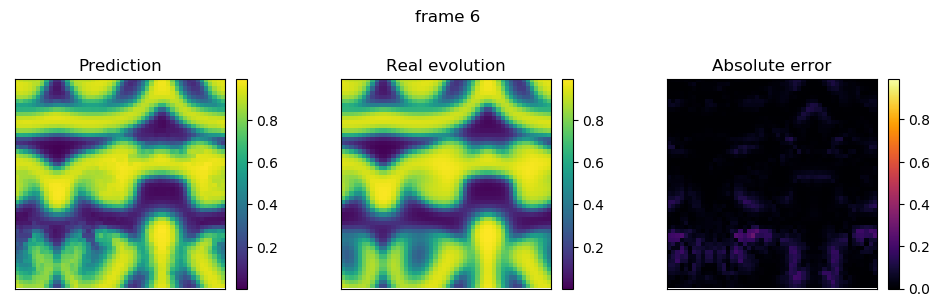

In [15]:
vmax = max(maximum(maximum(s) for s in test),
           maximum(maximum(s) for s in pred))
vmin = min(minimum(minimum(s) for s in test),
           minimum(minimum(s) for s in pred))
# plot plot plot
i = length(err)

    fig = figure(figsize=(10,3))
ax1 = subplot2grid((1,3), (0,0))
ax2 = subplot2grid((1,3), (0,1))
ax3 = subplot2grid((1,3), (0,2))

im1 = ax1.imshow(pred[i], cmap="viridis", vmin = vmin, vmax = vmax)
im2 = ax2.imshow(test[i], cmap="viridis", vmin = vmin, vmax = vmax)
im3 = ax3.imshow(err[i], cmap="inferno", vmin = 0, vmax = vmax-vmin)
for (im, ax) in zip([im1,im2,im3], [ax1,ax2,ax3])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    colorbar(im, ax = ax, fraction=0.046, pad=0.04)#, format="%.1f")
end
ax1.set_title("Prediction")
ax2.set_title("Real evolution")
ax3.set_title("Absolute error")
suptitle("frame $i")
tight_layout(w_pad=0.6, h_pad=0.00001)
subplots_adjust(top=0.75)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*